In [1]:
%matplotlib inline

import gzip

import pandas as pd
from urllib.parse import urlparse

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import warcio
from readability import Document
from langdetect import detect

In [2]:
data_path = 'CC-NEWS-20180228202022-00305.warc.gz'

In [3]:
df = pd.DataFrame(columns=['url', 'lang', 'title', 'summary'])
i = 0
with gzip.open(data_path) as f: 
    for record in warcio.archiveiterator.ArchiveIterator(f):
        if record.rec_type == 'warcinfo': 
            print(record.raw_stream.read())
        elif record.rec_type == 'response': 
            url = urlparse(record.rec_headers.get_header('WARC-Target-URI'))
            doc = Document(record.raw_stream.read())
            lang = detect(doc.title())
            df = df.append({'url': url.hostname, 'lang': lang, 'title': doc.title(), 'summary': doc.summary()},
                           ignore_index=True)
            if i == 200:
                break
            i = i + 1

b'software:: StormCrawler 1.8 http://stormcrawler.net/\r\ndescription: News crawl for Common Crawl\r\nhttp-header-user-agent: CCBot/3.0 (http://commoncrawl.org/faq/; info@commoncrawl.org)\r\nhttp-header-from: info@commoncrawl.org\r\nformat: WARC File Format 1.0\r\nconformsTo: http://bibnum.bnf.fr/WARC/WARC_ISO_28500_version1_latestdraft.pdf\r\n'


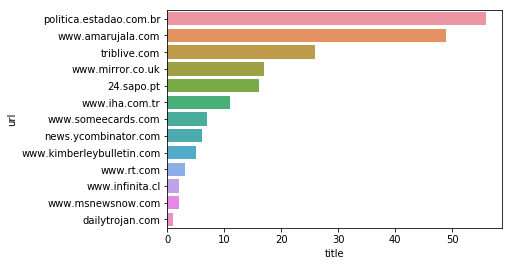

In [4]:
per_host = df.groupby(['url']).count().reset_index().sort_values(['title'], ascending=False).iloc[:20]
sns.barplot(y='url', x='title', data=per_host)

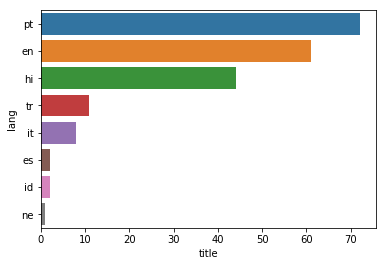

In [5]:
per_lang = df.groupby(['lang']).count().reset_index().sort_values(['title'], ascending=False).iloc[:20]
sns.barplot(y='lang', x='title', data=per_lang)